# M3.2: Comparison of numerical solutions to reference solutions

by Daniel Leitner, Andrea Schnepf 

## Benchmark M3.2(a)

For the comparison save the results in a text file with two lines, containing comma separated depth values [cm] in the first line, and pressure head [cm] in the second line. Locate the file in the folder `/M32a Numerical results/simulatorname`.  

## Benchmark M3.2(b)

For a comparison save the results in a text file with two lines, containing comma separated depth values [cm] in the first line, and pressure head [cm] in the second line. Locate the file in the folder `/M32b Numerical results/simulatorname`.

We compare different numerical codes by solving the benchmarking problems. The following links lead to Jupyter notebooks describing numerical codes implementing Benchmark M3.2:

* [Homegrown Python Code from Schnepf et al. 2018](Xylem flux - Python code.ipynb)
* [Dumux](Xylem flux - Dumux.ipynb)

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
from math import *
from rsml import * # located in the same directory 
from scipy.interpolate import interp1d

# normalized root mean squared error
def nRMSE(y_ana, y_num):
    assert len(y_ana)==len(y_num), "number of analytical solutions y_ana must equalt number of numerical solutions y_num"
    n = len(y_ana)
    rmse = np.sqrt(np.sum(np.square(y_ana-y_num))/n)
    return rmse/np.abs(np.mean(y_ana)) 

1. DuMuX (b*):
from  -498.4342348369011 to -240.76349069826708  cm pressure head

2. OpenSimRoot (g*):
from  -496.8 to 0.0  cm pressure head

3. RSWMS (r*):
from  -495.488 to -248.025  cm pressure head

4. Reference (m*):
from  -500.0 to -240.0903038863033  cm pressure head

5. SRI.txt (c*):
from  -500.0 to -240.647  cm pressure head

1. DuMuX (b*):
from  -498.1539086391437 to -199.24160614169216  cm pressure head

2. OpenSimRoot (g*):
from  -496.2 to 0.0  cm pressure head

3. RSWMS (r*):
from  -494.764 to -200.085  cm pressure head

4. Reference (m*):
from  -500.0 to -199.19187726413836  cm pressure head



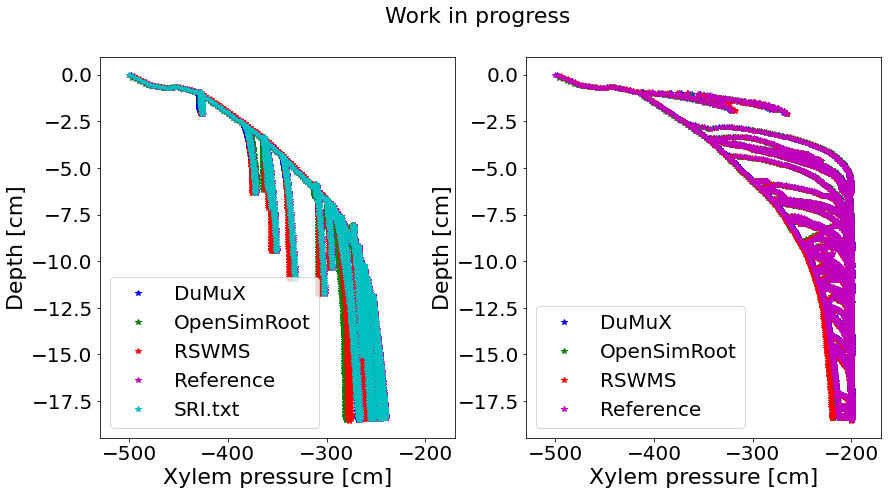

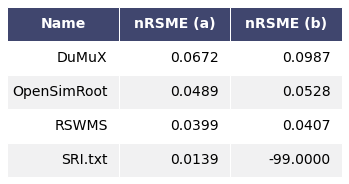

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(14,7)) 
col = ["b*", "g*", "r*", "m*", "c*"]
# M32a
# analytical solution
data = np.loadtxt("M32a Numerical results/"+"Reference",delimiter=',')
z_a = data[0,:]; psi_a = data[1,:];

l, nrsmea, namea=[],[],[]
for dirname, dirnames, filenames in os.walk('M32a Numerical results/.'):
    filenames.sort()
    for i,f in enumerate(filenames):
        try:
            l.append(f)
            data = np.loadtxt("M32a Numerical results/"+f,delimiter=',')        
            print(str(i+1)+". "+f+" ("+col[i]+"):")
            print("from ", min(data[1,:]), "to", max(data[1,:]), " cm pressure head\n")        
            pl, = ax[0].plot(data[1,:],data[0,:],col[i])
            if f!="Reference":
                z_n = data[0,:]; psi_n = data[1,:]
                interp = interp1d(z_n, psi_n,  kind='linear', fill_value='extrapolate', bounds_error =False ) 
                psi_n = interp(z_a)                 
                nrsmea.append(nRMSE(psi_a,psi_n))
                namea.append(f)
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(ex)             
ax[0].set_xlabel("Xylem pressure [cm]")  
ax[0].set_ylabel("Depth [cm]")  
ax[0].legend(l)

# M32b
# analytical solution
data = np.loadtxt("M32b Numerical results/"+"Reference",delimiter=',')
z_a = data[0,:]; psi_a = data[1,:];
l, nrsmeb, nameb=[],[],[]
for dirname, dirnames, filenames in os.walk('M32b Numerical results/.'):
    filenames.sort()
    for i,f in enumerate(filenames):
        try:
            l.append(f)
            data = np.loadtxt("M32b Numerical results/"+f,delimiter=',')        
            print(str(i+1)+". "+f+" ("+col[i]+"):")
            print("from ", min(data[1,:]), "to", max(data[1,:]), " cm pressure head\n")        
            #plt.plot(data[1,:],data[0,:],col[i])
            pl, = ax[1].plot(data[1,:],data[0,:],col[i])
            if f!="Reference":
                z_n = data[0,:]; psi_n = data[1,:]
                interp = interp1d(z_n, psi_n,  kind='linear', fill_value='extrapolate', bounds_error =False ) 
                psi_n = interp(z_a)                 
                nrsmeb.append(nRMSE(psi_a,psi_n))  
                nameb.append(f)
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(ex)
 
ax[1].set_xlabel("Xylem pressure [cm]")  
ax[1].set_ylabel("Depth [cm]")
ax[0].set_xlim(-530,-170) 
ax[1].set_xlim(-530,-170)
ax[1].legend(l)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title
plt.savefig('m32_results.png', dpi=300, bbox_inches = "tight")
fig.suptitle("Work in progress")
plt.show() 

import pandas as pd 
# initialize list of lists 
nrsmeb.append(-99)
data_ = np.array([namea, nrsmea, nrsmeb]); #data_b = pandas.concat([data_, additional], axis=1)
data_ = np.array(data_.transpose())

# Create the pandas DataFrame 
df = pd.DataFrame(data_, columns = ['Name','nRSME (a)','nRSME (b)'] )
df['nRSME (a)'] = df['nRSME (a)'].astype(float)
df['nRSME (a)'] = df['nRSME (a)'].map('{:,.4f}'.format)
df['nRSME (b)'] = df['nRSME (b)'].astype(float)
df['nRSME (b)'] = df['nRSME (b)'].map('{:,.4f}'.format)
# print dataframe. 
df.style.set_table_styles(
[{'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#eee')]}, 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 {'selector': 'th',
  'props': [('background', '#606060'), 
            ('color', 'white'),
            ('font-family', 'verdana')]},
 {'selector': 'td',
  'props': [('font-family', 'verdana')]},
]
).hide_index()
import six
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(df, header_columns=0, col_width=2.0)
fig.savefig("table_m32.png")
